In [6]:
import os
from openai import AzureOpenAI
    
client = AzureOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),  
    api_version="2023-12-01-preview",
    azure_endpoint=os.getenv("OPENAI_API_BASE")
)

In [17]:
dataset_path = '../../dataset/high_traffic/graph.csv'

In [21]:
import pandas as pd
df = pd.read_csv(dataset_path)
# create a list of column names
columns = df.columns.tolist()
# remove the first column name
columns.remove(columns[0])
columns

['169.254.170.2_remote',
 'AWSSimpleSystemsManagement_AWS::AWSSimpleSystemsManagement',
 'DynamoDB_AWS::DynamoDB',
 'Evidently_AWS::Evidently',
 'PGSQL Query_remote',
 'PetAdoptionStatusUpdater/prod_AWS::ApiGateway::Stage',
 'PetSearch_AWS::ECS::Fargate',
 'PetSearch_client',
 'PetSite',
 'SSM_AWS::SSM',
 'STS_AWS::STS',
 'SimpleNotificationService_AWS::SimpleNotificationService',
 'SimpleSystemsManagement_AWS::SimpleSystemsManagement',
 'StepFnStateMachine76D362E8-T67Tg48ke8oK_client',
 'amazon.com_remote',
 'lambda_step_priceGreaterThan55',
 'lambda_step_priceGreaterThan55_AWS::Lambda',
 'lambda_step_priceGreaterThan55_AWS::Lambda::Function',
 'lambda_step_priceLessThan55',
 'lambda_step_priceLessThan55_AWS::Lambda',
 'lambda_step_priceLessThan55_AWS::Lambda::Function',
 'lambda_step_readDDB',
 'lambda_step_readDDB_AWS::Lambda',
 'lambda_step_readDDB_AWS::Lambda::Function',
 'lambdastatusupdater_AWS::Lambda',
 'lambdastatusupdater_AWS::Lambda::Function',
 'payforadoption_AWS::ECS::Co

In [15]:
context_prompt = '''This project contains a metrics generated by adapting a PetShop application. 
Performance issues were triggered in various microservices of this application leading to increased latency and reduced availability.
The task of root-cause analysis (RCA) is to identify the source of such issues. This is an important step to mitigate and resolve the issue. Identifying the root cause of such issues, however, can be extremely cumbersome and time-consuming, particularly in complex applications composed of tens or hundreds of microservices.
'''

In [32]:
query_prompt='''Should there be a direct causal link between {node_a} and {node_b}? Provide a detailed explanation.'''

In [36]:
query_prompt ='''Given the list of nodes : {list}. List 20 edges that are most likely to be the root cause of the performance issue. Provide a detailed explanation for each edge.'''

In [37]:
query_prompt = query_prompt.format(list=columns)
print(query_prompt)

Given the list of nodes : ['169.254.170.2_remote', 'AWSSimpleSystemsManagement_AWS::AWSSimpleSystemsManagement', 'DynamoDB_AWS::DynamoDB', 'Evidently_AWS::Evidently', 'PGSQL Query_remote', 'PetAdoptionStatusUpdater/prod_AWS::ApiGateway::Stage', 'PetSearch_AWS::ECS::Fargate', 'PetSearch_client', 'PetSite', 'SSM_AWS::SSM', 'STS_AWS::STS', 'SimpleNotificationService_AWS::SimpleNotificationService', 'SimpleSystemsManagement_AWS::SimpleSystemsManagement', 'StepFnStateMachine76D362E8-T67Tg48ke8oK_client', 'amazon.com_remote', 'lambda_step_priceGreaterThan55', 'lambda_step_priceGreaterThan55_AWS::Lambda', 'lambda_step_priceGreaterThan55_AWS::Lambda::Function', 'lambda_step_priceLessThan55', 'lambda_step_priceLessThan55_AWS::Lambda', 'lambda_step_priceLessThan55_AWS::Lambda::Function', 'lambda_step_readDDB', 'lambda_step_readDDB_AWS::Lambda', 'lambda_step_readDDB_AWS::Lambda::Function', 'lambdastatusupdater_AWS::Lambda', 'lambdastatusupdater_AWS::Lambda::Function', 'payforadoption_AWS::ECS::Co

In [33]:
# pass the variables node a and node b into the query prompt from the columns list
query_prompt = query_prompt.format(node_a=columns[0], node_b=columns[1])
query_prompt

'Should there be a direct causal link between 169.254.170.2_remote and AWSSimpleSystemsManagement_AWS::AWSSimpleSystemsManagement? Provide a detailed explanation.\n    """'

In [90]:
query_prompt = f'''Given the list of nodes: {columns}. List 40 edges that represent a causal relationship between the nodes based on the list provided. For each edge, use the format `Edge: (Node1 -> Node2), Explanation: [detailed explanation]`. Ensure each edge represents a causal relationship between the nodes and provide a detailed explanation for each edge.'''

In [91]:
messages=[]
messages.append({"role": "system", "content": context_prompt})
messages.append({"role": "user", "content": query_prompt})
 
chat_completion = client.chat.completions.create(     
    model="gpt-4",
    messages=messages
)

In [92]:
result=chat_completion.choices[0].message.content
result

"1. Edge: (PetSearch_client -> PetSearch_AWS::ECS::Fargate), Explanation: The PetSearch client sends a request to the PetSearch Fargate microservice to fetch a list of pets.\n\n2. Edge: (PetSearch_AWS::ECS::Fargate -> PetSite), Explanation: The PetSearch Fargate microservice forwards the fetched list of pets to the PetSite.\n\n3. Edge: (PetSite -> '169.254.170.2_remote'), Explanation: The PetSite sends the list of pets back to the client's IP address.\n\n4. Edge: (SSM_AWS::SSM -> petInfo_AWS::DynamoDB::Table), Explanation: The SSM service interacts with the petInfo DynamoDB Table to fetch or manage pets data.\n\n5. Edge: (DynamoDB_AWS::DynamoDB -> lambda_step_readDDB), Explanation: The DynamoDB AWS interacts with the lambda function to read from the database.\n\n6. Edge: (PetAdoptionStatusUpdater/prod_AWS::ApiGateway::Stage -> lambdastatusupdater_AWS::Lambda), Explanation: The StatusUpdater API Gateway triggers the Lambda function to update pet status.\n\n7. Edge: (lambdastatusupdater_

In [96]:
import re
def parse_edges(response):
    # edge_pattern = re.compile(r'Edge: \((.*?) -> (.*?)\), Explanation: \[(.*?)\]')
    # edge_pattern = re.compile(r'Edge: \((.*?) -> (.*?)\),Explanation: (.*?)\n\n')
    edge_pattern = re.compile(r'Edge: \((.*?) -> (.*?)\), Explanation: (.*?)\.\n')
    matches = edge_pattern.findall(response)
    # print(matches)
    edges = [{"Node1": match[0], "Node2": match[1], "Explanation": match[2]} for match in matches]
    return edges

parsed_edges = parse_edges(result)
for edge in parsed_edges:
    print(edge)


{'Node1': 'PetSearch_client', 'Node2': 'PetSearch_AWS::ECS::Fargate', 'Explanation': 'The PetSearch client sends a request to the PetSearch Fargate microservice to fetch a list of pets'}
{'Node1': 'PetSearch_AWS::ECS::Fargate', 'Node2': 'PetSite', 'Explanation': 'The PetSearch Fargate microservice forwards the fetched list of pets to the PetSite'}
{'Node1': 'PetSite', 'Node2': "'169.254.170.2_remote'", 'Explanation': "The PetSite sends the list of pets back to the client's IP address"}
{'Node1': 'SSM_AWS::SSM', 'Node2': 'petInfo_AWS::DynamoDB::Table', 'Explanation': 'The SSM service interacts with the petInfo DynamoDB Table to fetch or manage pets data'}
{'Node1': 'DynamoDB_AWS::DynamoDB', 'Node2': 'lambda_step_readDDB', 'Explanation': 'The DynamoDB AWS interacts with the lambda function to read from the database'}
{'Node1': 'PetAdoptionStatusUpdater/prod_AWS::ApiGateway::Stage', 'Node2': 'lambdastatusupdater_AWS::Lambda', 'Explanation': 'The StatusUpdater API Gateway triggers the Lamb

In [105]:
parsed_edges=[{'Node1': 'PetSearch_client', 'Node2': 'PetSearch_AWS::ECS::Fargate', 'Explanation': 'The PetSearch client sends a request to the PetSearch Fargate microservice to fetch a list of pets'},
{'Node1': 'PetSearch_AWS::ECS::Fargate', 'Node2': 'PetSite', 'Explanation': 'The PetSearch Fargate microservice forwards the fetched list of pets to the PetSite'},
{'Node1': 'PetSite', 'Node2': "'169.254.170.2_remote'", 'Explanation': "The PetSite sends the list of pets back to the client's IP address"},
{'Node1': 'SSM_AWS::SSM', 'Node2': 'petInfo_AWS::DynamoDB::Table', 'Explanation': 'The SSM service interacts with the petInfo DynamoDB Table to fetch or manage pets data'},
{'Node1': 'DynamoDB_AWS::DynamoDB', 'Node2': 'lambda_step_readDDB', 'Explanation': 'The DynamoDB AWS interacts with the lambda function to read from the database'},
{'Node1': 'PetAdoptionStatusUpdater/prod_AWS::ApiGateway::Stage', 'Node2': 'lambdastatusupdater_AWS::Lambda', 'Explanation': 'The StatusUpdater API Gateway triggers the Lambda function to update pet status'},
{'Node1': 'lambdastatusupdater_AWS::Lambda', 'Node2': 'lambda_step_priceGreaterThan55', 'Explanation': 'The lambda function further triggers price check for adoption if the price of the pet is greater than 55'},
{'Node1': 'lambda_step_priceGreaterThan55', 'Node2': 'lambda_step_priceGreaterThan55_AWS::Lambda', 'Explanation': 'The lambda_step_priceGreaterThan55 stage triggers a lambda function to perform the check on the price'},
{'Node1': 'AWSSimpleSystemsManagement_AWS::AWSSimpleSystemsManagement', 'Node2': 'SSM_AWS::SSM', 'Explanation': 'AWS Simple Systems Management (SSM) service interacts with SSM AWS to manage system parameters or configurations'},
{'Node1': 'lambda_step_priceGreaterThan55_AWS::Lambda', 'Node2': 'lambda_step_readDDB_AWS::Lambda', 'Explanation': 'Lambda function for price check triggers another lambda function to read data from DynamoDB'},
{'Node1': 'Evidently_AWS::Evidently', 'Node2': 'SimpleSystemsManagement_AWS::SimpleSystemsManagement', 'Explanation': 'Evidently service communicates with Simple Systems Management to evaluate systems'},
{'Node1': 'PetSearch_AWS::ECS::Fargate', 'Node2': 'PetSearch_client', 'Explanation': 'The PetSearch service returns the search result to the client'},
{'Node1': 'DynamoDB_AWS::DynamoDB', 'Node2': 'PetSearch_AWS::ECS::Fargate', 'Explanation': 'DynamoDB service provides the search data to the PetSearch Fargate microservice'},
{'Node1': 'PetSite', 'Node2': 'lambda_step_priceLessThan55', 'Explanation': 'If the user chooses a pet with a price less than 55, PetSite triggers the price check lambda function'},
{'Node1': 'lambda_step_priceLessThan55', 'Node2': 'lambda_step_priceLessThan55_AWS::Lambda', 'Explanation': "The step triggers the respective Lambda function to perform a check on the price if it's less than 55"},
{'Node1': 'PetSearch_client', 'Node2': 'STS_AWS::STS', 'Explanation': 'Client may need to directly interact with Security Token Service (STS) to get temporary security credentials'},
{'Node1': 'petlistadoptions_AWS::ECS::Fargate', 'Node2': 'petlistadoptions_client', 'Explanation': 'Pet Adoption Lists microservice returns the adoption data to the client'},
{'Node1': 'payforadoption_AWS::ECS::Container', 'Node2': 'payforadoption_client', 'Explanation': 'The Pay For Adoption service returns the adoption payment status to the client'},
{'Node1': 'StepFnStateMachine76D362E8-T67Tg48ke8oK_client', 'Node2': 'AWS::StepFunctions::StateMachine', 'Explanation': 'The Step Function State Machine client sends a request to start an execution of the step function state machine'},
{'Node1': 'SimpleNotificationService_AWS::SimpleNotificationService', 'Node2': 'PetSearch_client', 'Explanation': 'Simple Notification Service can send a notification to the PetSearch client when pets are added or removed'},
{'Node1': 'execute-api.us-west-2.amazonaws.com_remote', 'Node2': 'PetAdoptionStatusUpdater/prod_AWS::ApiGateway::Stage', 'Explanation': 'External API execution triggers the update on the Pet Adoption status'},
{'Node1': 'PetSearch_AWS::ECS::Fargate', 'Node2': 'www.amazon.com_remote', 'Explanation': 'The PetSearch service can request information from Amazon.com'},
{'Node1': 'lambdastatusupdater_AWS::Lambda::Function', 'Node2': 'SimpleNotificationService_AWS::SimpleNotificationService', 'Explanation': 'Lambda function can trigger a notification through Simple Notification Service'},
{'Node1': 'STS_AWS::STS', 'Node2': 'PetSearch_AWS::ECS::Fargate', 'Explanation': 'STS can provide temporary security credentials to authenticate the PetSearch service'},
{'Node1': 'servi-searc.us-west-2.elb.amazonaws.com_remote', 'Node2': 'PetSearch_AWS::ECS::Fargate', 'Explanation': 'The Search service sends requests to the PetSearch Fargate microservice'},
{'Node1': 'Servi-searc.us-west-2.elb.amazonaws.com_remote', 'Node2': 'PetSearch_client', 'Explanation': 'The Search service sends the fetched data to the PetSearch client'},
{'Node1': 'lambda_step_priceGreaterThan55_AWS::Lambda::Function', 'Node2': 'StepFunctions_AWS::StepFunctions', 'Explanation': 'The Lambda function triggers a step function when the adoption price is greater than 55'},
{'Node1': 'payforadoption_AWS::ECS::Container', 'Node2': 'SimpleNotificationService_AWS::SimpleNotificationService', 'Explanation': 'Pay for adoption container can communicate with the Simple Notification Service to send notifications about payment status'},
{'Node1': 'PetSearch_client', 'Node2': 'PetSearch_AWS::ECS::Fargate', 'Explanation': 'PetSearch client sends search queries to the PetSearch service'},
{'Node1': 'S3_AWS::S3', 'Node2': 'PetSite', 'Explanation': 'S3 can provide static files such as images, CSS or JavaScript files to the front-end PetSite'},
{'Node1': 'payforadoption_AWS::ECS::Container', 'Node2': 'AWS::StepFunctions::StateMachine', 'Explanation': 'Pay for adoption container triggers step function to process payment'},
{'Node1': 'lambdastatusupdater_AWS::Lambda', 'Node2': 'SimpleNotificationService_AWS::SimpleNotificationService', 'Explanation': 'Lambda function for updating status interacts with the Simple Notification Service to send notifications about status change'},
{'Node1': 'SSM_AWS::SSM', 'Node2': 'AWSSimpleSystemsManagement_AWS::AWSSimpleSystemsManagement', 'Explanation': 'SSM service queries AWS Simple Systems Management for system commands and configurations'},
{'Node1': 'AWSSimpleSystemsManagement_AWS::AWSSimpleSystemsManagement', 'Node2': 'lambda_step_priceGreaterThan55', 'Explanation': 'Simple Systems Management service triggers Lambda function when system events happen like the adoption price being greater than 55'},
{'Node1': 'lambda_step_priceLessThan55_AWS::Lambda', 'Node2': 'StepFunctions_AWS::StepFunctions', 'Explanation': 'The Lambda function triggers a step function when adoption price is less than 55'},
{'Node1': 'servi-lista.us-west-2.elb.amazonaws.com_remote', 'Node2': 'petlistadoptions_AWS::ECS::Fargate', 'Explanation': 'The List service sends requests to the PetListAdoptions Fargate service'},
{'Node1': 'servi-payfo.us-west-2.elb.amazonaws.com_remote', 'Node2': 'payforadoption_AWS::ECS::Container', 'Explanation': 'The Pay service sends requests to the PayForAdoption container to initiate the payment process'},
{'Node1': 'https://sqs.us-west-2.amazonaws.com/Services-sqspetadoption_AWS::SQS::Queue', 'Node2': 'SimpleNotificationService_AWS::SimpleNotificationService', 'Explanation': 'The SQS service can feed messages into SNS when there is a change in pet adoption'}]


In [69]:
# Create a mapping from original labels to numbers
label_mapping = {label: i for i, label in enumerate(columns)}
label_mapping

{'169.254.170.2_remote': 0,
 'AWSSimpleSystemsManagement_AWS::AWSSimpleSystemsManagement': 1,
 'DynamoDB_AWS::DynamoDB': 2,
 'Evidently_AWS::Evidently': 3,
 'PGSQL Query_remote': 4,
 'PetAdoptionStatusUpdater/prod_AWS::ApiGateway::Stage': 5,
 'PetSearch_AWS::ECS::Fargate': 6,
 'PetSearch_client': 7,
 'PetSite': 8,
 'SSM_AWS::SSM': 9,
 'STS_AWS::STS': 10,
 'SimpleNotificationService_AWS::SimpleNotificationService': 11,
 'SimpleSystemsManagement_AWS::SimpleSystemsManagement': 12,
 'StepFnStateMachine76D362E8-T67Tg48ke8oK_client': 13,
 'amazon.com_remote': 14,
 'lambda_step_priceGreaterThan55': 15,
 'lambda_step_priceGreaterThan55_AWS::Lambda': 16,
 'lambda_step_priceGreaterThan55_AWS::Lambda::Function': 17,
 'lambda_step_priceLessThan55': 18,
 'lambda_step_priceLessThan55_AWS::Lambda': 19,
 'lambda_step_priceLessThan55_AWS::Lambda::Function': 20,
 'lambda_step_readDDB': 21,
 'lambda_step_readDDB_AWS::Lambda': 22,
 'lambda_step_readDDB_AWS::Lambda::Function': 23,
 'lambdastatusupdater_AWS

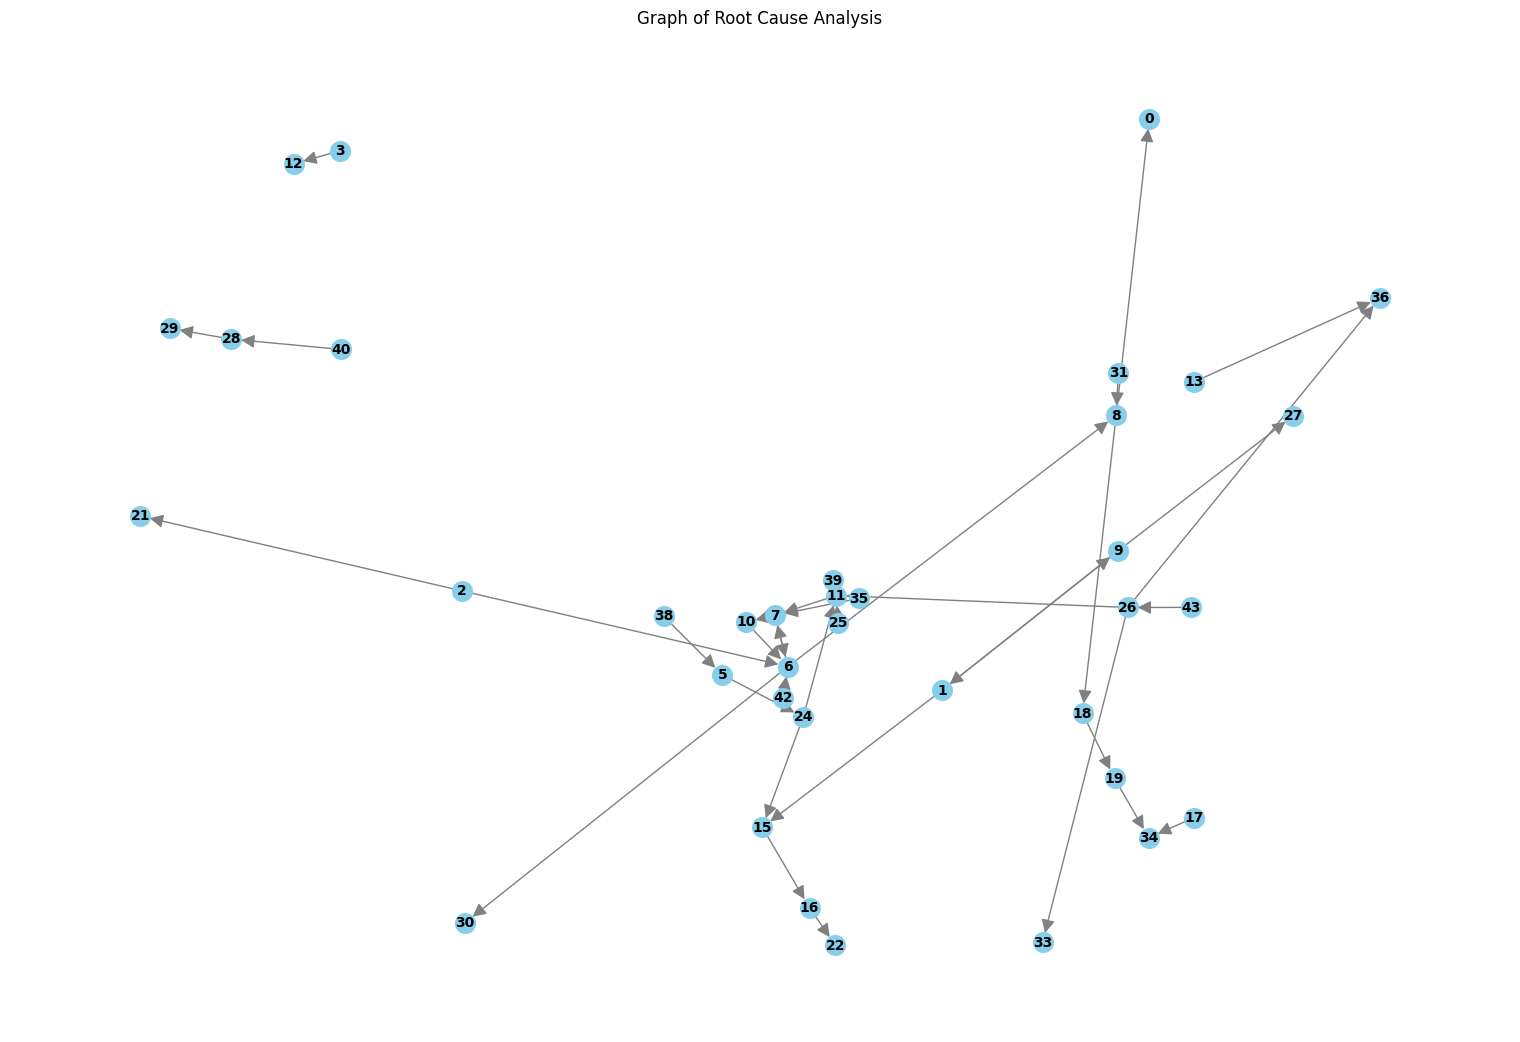

In [106]:
# create a graph in networkx using the edges provided above and the labels
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for edge in parsed_edges:
    node1 = edge['Node1'].strip("'")
    node2 = edge['Node2'].strip("'")
    G.add_edge(label_mapping[node1], label_mapping[node2])

# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray", linewidths=1, arrowsize=20)
plt.title("Graph of Root Cause Analysis")
plt.show()

In [108]:
# create a 44x44 matrix with zeros 
adj_matrix = [[0 for _ in range(len(columns))] for _ in range(len(columns))]
# fill the matrix with 1s for each edge
for edge in parsed_edges:
    node1 = edge['Node1'].strip("'")
    node2 = edge['Node2'].strip("'")
    adj_matrix[label_mapping[node1]][label_mapping[node2]] = 1

In [109]:
# count the number of edges in the adjacency matrix
num_edges = sum(sum(row) for row in adj_matrix)
num_edges

37

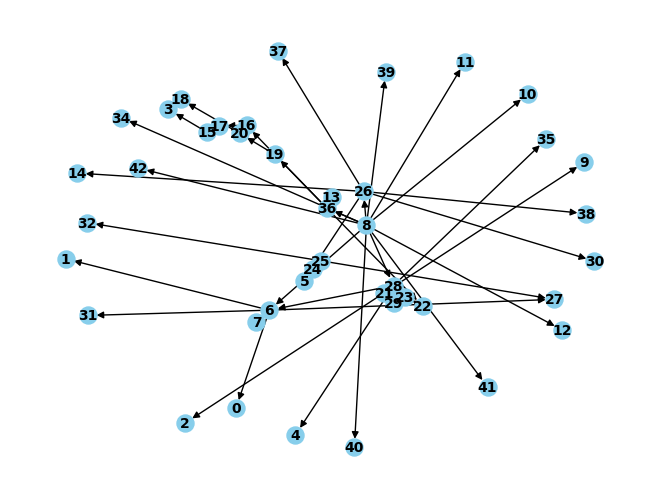

In [120]:
dataset_path = '../../dataset/low_traffic/graph.csv'
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv(dataset_path, index_col=0)

# Replace the labels in the DataFrame
df.rename(index=label_mapping, columns=label_mapping, inplace=True)

# Convert the DataFrame to a networkx graph
G_true = nx.from_pandas_adjacency(df,create_using=nx.DiGraph)

# Draw the graph
pos = nx.spring_layout(G_true)  # Define the layout for the nodes
nx.draw(G_true, pos, with_labels=True, labels={node: str(node) for node in G_true.nodes()}, node_size=150, node_color='skyblue', font_size=10, font_weight='bold')  # Draw the graph

# Display the graph
plt.show()

In [121]:
# calculate the number of correct edges in the predicted graph
correct_edges = sum([adj_matrix[i][j] for i in range(len(columns)) for j in range(len(columns) ) if G_true.has_edge(i, j)])
correct_edges

3

In [122]:
# print all the correct edges
correct_edges = [{"Node1": columns[i], "Node2": columns[j]} for i in range(len(columns)) for j in range(len(columns)) if G_true.has_edge(i, j) and adj_matrix[i][j] == 1]
correct_edges

[{'Node1': 'PetAdoptionStatusUpdater/prod_AWS::ApiGateway::Stage',
  'Node2': 'lambdastatusupdater_AWS::Lambda'},
 {'Node1': 'PetSearch_client', 'Node2': 'PetSearch_AWS::ECS::Fargate'},
 {'Node1': 'StepFnStateMachine76D362E8-T67Tg48ke8oK_client',
  'Node2': 'AWS::StepFunctions::StateMachine'}]